In [1]:
!nvidia-smi

Sat May 23 12:18:59 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
!pip --quiet install transformers
!pip --quiet install tokenizers

     |████████████████████████████████| 665kB 2.7MB/s 
     |████████████████████████████████| 3.8MB 13.2MB/s 
     |████████████████████████████████| 1.1MB 27.5MB/s 
     |████████████████████████████████| 890kB 52.3MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp -r '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Scripts/.' .

In [0]:
COLAB_BASE_PATH = '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/'
MODEL_BASE_PATH = COLAB_BASE_PATH + 'Models/Files/172-roBERTa_base/'

import os
os.mkdir(MODEL_BASE_PATH)

## Dependencies

In [6]:
import json, warnings, shutil
from scripts_step_lr_schedulers import *
from tweet_utility_scripts import *
from tweet_utility_preprocess_roberta_scripts_aux import *
import tweet_utility_preprocess_roberta_scripts_text as preprocess_text
from transformers import TFRobertaModel, RobertaConfig
from tokenizers import ByteLevelBPETokenizer
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, metrics, losses, layers

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load data

In [0]:
# Unzip files
!tar -xf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete_96/no_qa_fold_1.tar.gz'
!tar -xf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete_96/no_qa_fold_2.tar.gz'
!tar -xf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete_96/no_qa_fold_3.tar.gz'
!tar -xf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete_96/no_qa_fold_4.tar.gz'
!tar -xf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete_96/no_qa_fold_5.tar.gz'

In [8]:
database_base_path = COLAB_BASE_PATH + 'Data/complete_96/'
k_fold = pd.read_csv(database_base_path + '5-fold.csv')
display(k_fold.head())

,textID,text,selected_text,sentiment,jaccard,text_len,text_wordCnt,text_tokenCnt,selected_text_len,selected_text_wordCnt,selected_text_tokenCnt,fold_1,fold_2,fold_3,fold_4,fold_5
0,cb774db0d1,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,1.000000,35,7,10,35,7,10,train,train,train,validation,train
1,549e992a42,sooo sad i will miss you here in san diego!!!,sooo sad,negative,0.200000,45,10,13,8,2,3,validation,train,train,train,train
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667,25,5,6,11,2,2,train,validation,train,train,train
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000,30,5,6,14,3,3,train,validation,train,train,train
4,358bd9e861,"sons of ****, why couldn`t they put them on th...","sons of ****,",negative,0.214286,74,14,17,13,3,4,train,train,validation,train,train


# Model parameters

In [0]:
vocab_path = COLAB_BASE_PATH + 'qa-transformers/roberta/roberta-base-vocab.json'
merges_path = COLAB_BASE_PATH + 'qa-transformers/roberta/roberta-base-merges.txt'
base_path = COLAB_BASE_PATH + 'qa-transformers/roberta/'

config = {
  "MAX_LEN": 96,
  "BATCH_SIZE": 32,
  "EPOCHS": 4,
  "LEARNING_RATE": 3e-5,
  "ES_PATIENCE": 4,
  "question_size": 0,
  "N_FOLDS": 5,
  "base_model_path": base_path + 'roberta-base-tf_model.h5',
  "config_path": base_path + 'roberta-base-config.json'
}

with open(MODEL_BASE_PATH + 'config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)

# Tokenizer

In [0]:
tokenizer = ByteLevelBPETokenizer(vocab_file=vocab_path, merges_file=merges_path, 
                                  lowercase=True, add_prefix_space=True)

## Learning rate schedule

Learning rate schedule: 3e-05 to 3e-05 to 1e-06


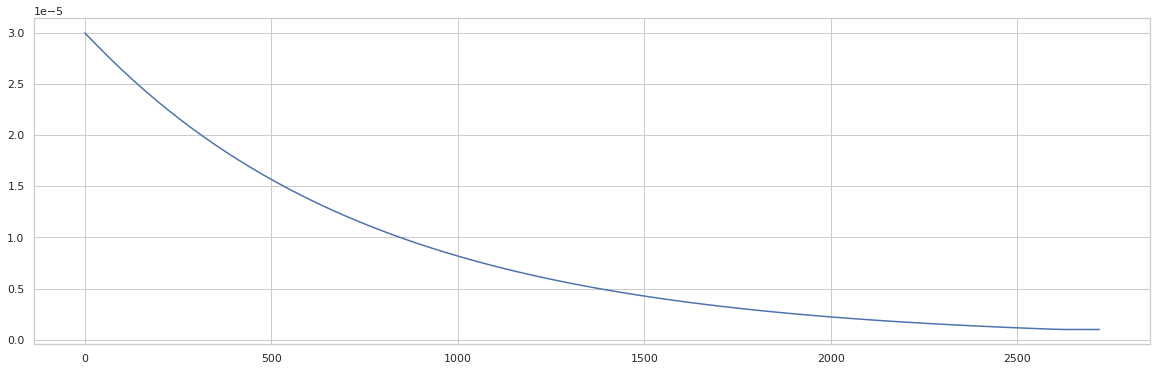

In [11]:
lr_min = 1e-6
lr_max = config['LEARNING_RATE']
train_size = len(k_fold[k_fold['fold_1'] == 'train'])
step_size = train_size // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * step_size
decay = .9987

rng = [i for i in range(0, total_steps, config['BATCH_SIZE'])]
y = [exponential_schedule_with_warmup(tf.cast(x, tf.float32), warmup_steps=1, lr_start=lr_max, lr_max=lr_max, lr_min=lr_min, decay=decay) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [0]:
module_config = RobertaConfig.from_pretrained(config['config_path'], output_hidden_states=False)

def model_fn(MAX_LEN):
    input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_mask = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')
    input_sentiment = layers.Input(shape=(3,), dtype=tf.float32, name='input_sentiment')
    
    base_model = TFRobertaModel.from_pretrained(config['base_model_path'], config=module_config, name="base_model")
    last_hidden_state, _ = base_model({'input_ids': input_ids, 'attention_mask': attention_mask})
    
    x_start_negative = layers.Dropout(.1)(last_hidden_state)
    x_start_negative = layers.Dense(1)(x_start_negative)
    x_start_negative = layers.Flatten()(x_start_negative)
    y_start_negative = layers.Activation('softmax', name='y_start_negative')(x_start_negative)
    y_start_negative = layers.Multiply()([y_start_negative, input_sentiment[:,0]])
    
    x_start_neutral = layers.Dropout(.1)(last_hidden_state)
    x_start_neutral = layers.Dense(1)(x_start_neutral)
    x_start_neutral = layers.Flatten()(x_start_neutral)
    y_start_neutral = layers.Activation('softmax', name='y_start_neutral')(x_start_neutral)
    y_start_neutral = layers.Multiply()([y_start_neutral, input_sentiment[:,1]])
    
    x_start_positive = layers.Dropout(.1)(last_hidden_state)
    x_start_positive = layers.Dense(1)(x_start_positive)
    x_start_positive = layers.Flatten()(x_start_positive)
    y_start_positive = layers.Activation('softmax', name='y_start_positive')(x_start_positive)
    y_start_positive = layers.Multiply()([y_start_positive, input_sentiment[:,2]])

    y_start_sum = layers.Add(name='y_start_avg')([y_start_negative, y_start_neutral, y_start_positive])
    
    x_start = layers.Dropout(.1)(last_hidden_state)
    x_start = layers.Dense(1)(x_start)
    x_start = layers.Flatten()(x_start)
    y_start = layers.Activation('softmax')(x_start)
    y_start = layers.Average(name='y_start')([y_start, y_start_sum])

    x_end_negative = layers.Dropout(.1)(last_hidden_state)
    x_end_negative = layers.Dense(1)(x_end_negative)
    x_end_negative = layers.Flatten()(x_end_negative)
    y_end_negative = layers.Activation('softmax', name='y_end_negative')(x_end_negative)
    y_end_negative = layers.Multiply()([y_end_negative, input_sentiment[:,0]])

    x_end_neutral = layers.Dropout(.1)(last_hidden_state)
    x_end_neutral = layers.Dense(1)(x_end_neutral)
    x_end_neutral = layers.Flatten()(x_end_neutral)
    y_end_neutral = layers.Activation('softmax', name='y_end_neutral')(x_end_neutral)
    y_end_neutral = layers.Multiply()([y_end_neutral, input_sentiment[:,1]])

    x_end_positive = layers.Dropout(.1)(last_hidden_state)
    x_end_positive = layers.Dense(1)(x_end_positive)
    x_end_positive = layers.Flatten()(x_end_positive)
    y_end_positive = layers.Activation('softmax', name='y_end_positive')(x_end_positive)
    y_end_positive = layers.Multiply()([y_end_positive, input_sentiment[:,2]])

    y_end_sum = layers.Add(name='y_end_avg')([y_end_negative, y_end_neutral, y_end_positive])

    x_end = layers.Dropout(.1)(last_hidden_state)
    x_end = layers.Dense(1)(x_end)
    x_end = layers.Flatten()(x_end)
    y_end = layers.Activation('softmax')(x_end)
    y_end = layers.Average(name='y_end')([y_end, y_end_sum])
    
    model = Model(inputs=[input_ids, attention_mask, input_sentiment], outputs=[y_start, y_end])
    
    return model

# Train

In [0]:
def get_training_dataset(x_train, y_train, batch_size, buffer_size, seed=0):
    dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': x_train[0], 'attention_mask': x_train[1], 'input_sentiment': x_train[2]}, 
                                                  {'y_start': y_train[0],'y_end': y_train[1]}))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048, seed=seed)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_validation_dataset(x_valid, y_valid, batch_size, buffer_size, repeated=False, seed=0):
    dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': x_valid[0], 'attention_mask': x_valid[1], 'input_sentiment': x_valid[2]}, 
                                                  {'y_start': y_valid[0],'y_end': y_valid[1]}))
    if repeated:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(2048, seed=seed)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.cache()
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_test_dataset(x_test, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices({'input_ids': x_test[0], 'attention_mask': x_test[1], 'input_sentiment': x_test[2]})
    dataset = dataset.batch(batch_size)
    return dataset

In [14]:
AUTO = tf.data.experimental.AUTOTUNE
strategy = tf.distribute.get_strategy()
k_fold_best = k_fold.copy()
history_list = []

for n_fold in range(config['N_FOLDS']):
    n_fold +=1
    print('\nFOLD: %d' % (n_fold))

    # Load data
    base_data_path = 'no_qa_fold_%d/' % (n_fold)
    x_train = np.load(base_data_path + 'x_train.npy')
    x_train_aux2 = np.load(base_data_path + 'x_train_aux2.npy')
    y_train = np.load(base_data_path + 'y_train.npy')
    x_valid = np.load(base_data_path + 'x_valid.npy')
    x_valid_aux2 = np.load(base_data_path + 'x_valid_aux2.npy')
    y_valid = np.load(base_data_path + 'y_valid.npy')
    
    step_size = x_train.shape[1] // config['BATCH_SIZE']
    valid_step_size = x_valid.shape[1] // config['BATCH_SIZE']

    # Build TF datasets
    train_dist_ds = strategy.experimental_distribute_dataset(get_training_dataset((*x_train, x_train_aux2), y_train, config['BATCH_SIZE'], AUTO, seed=SEED))
    valid_dist_ds = strategy.experimental_distribute_dataset(get_validation_dataset((*x_valid, x_valid_aux2), y_valid, config['BATCH_SIZE'], AUTO, repeated=True, seed=SEED))
    train_data_iter = iter(train_dist_ds)
    valid_data_iter = iter(valid_dist_ds)
    
    # Step functions
    @tf.function
    def train_step(data_iter):
        def train_step_fn(x, y):
            with tf.GradientTape() as tape:
                probabilities = model(x, training=True)
                loss_start = loss_fn(y['y_start'], probabilities[0])
                loss_end = loss_fn(y['y_end'], probabilities[1])
                loss = tf.math.add(loss_start, loss_end)
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            # update metrics
            train_loss.update_state(loss)
            train_loss_start.update_state(loss_start)
            train_loss_end.update_state(loss_end)
        for _ in tf.range(step_size):
            strategy.experimental_run_v2(train_step_fn, next(data_iter))

    @tf.function
    def valid_step(data_iter):
        def valid_step_fn(x, y):
            probabilities = model(x, training=False)
            loss_start = loss_fn(y['y_start'], probabilities[0])
            loss_end = loss_fn(y['y_end'], probabilities[1])
            loss = tf.math.add(loss_start, loss_end)
            # update metrics
            valid_loss.update_state(loss)
            valid_loss_start.update_state(loss_start)
            valid_loss_end.update_state(loss_end)
        for _ in tf.range(valid_step_size):
            strategy.experimental_run_v2(valid_step_fn, next(data_iter))

    # Train model
    model_path = 'model_fold_%d.h5' % (n_fold)
    model = model_fn(config['MAX_LEN'])
    optimizer = optimizers.Adam(learning_rate=lambda: exponential_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), warmup_steps=1, 
                                                                                       lr_start=lr_max, lr_max=lr_max, lr_min=lr_min, decay=decay))
    loss_fn = losses.categorical_crossentropy
    train_loss = metrics.Sum()
    valid_loss = metrics.Sum()
    train_loss_start = metrics.Sum()
    valid_loss_start = metrics.Sum()
    train_loss_end = metrics.Sum()
    valid_loss_end = metrics.Sum()
        
    metrics_dict = {'loss': train_loss, 'loss_start': train_loss_start, 'loss_end': train_loss_end, 
                    'val_loss': valid_loss, 'val_loss_start': valid_loss_start, 'val_loss_end': valid_loss_end}
        
    history = custom_fit(model, metrics_dict, train_step, valid_step, train_data_iter, valid_data_iter, 
                         step_size, valid_step_size, config['BATCH_SIZE'], config['EPOCHS'], config['ES_PATIENCE'], 
                         (MODEL_BASE_PATH + model_path), save_last=False)
    
    history_list.append(history)
    model.save_weights(MODEL_BASE_PATH +'last_' + model_path)
    
    # Make predictions (last model)
    x_train = np.load(base_data_path + 'x_train.npy')
    x_valid = np.load(base_data_path + 'x_valid.npy')
    train_preds = model.predict(get_test_dataset((*x_train, x_train_aux2), config['BATCH_SIZE']))
    valid_preds = model.predict(get_test_dataset((*x_valid, x_valid_aux2), config['BATCH_SIZE']))
    
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'train', 'start_fold_%d' % (n_fold)] = train_preds[0].argmax(axis=-1)
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'train', 'end_fold_%d' % (n_fold)] = train_preds[1].argmax(axis=-1)
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'validation', 'start_fold_%d' % (n_fold)] = valid_preds[0].argmax(axis=-1)
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'validation', 'end_fold_%d' % (n_fold)] = valid_preds[1].argmax(axis=-1)
    
    k_fold['end_fold_%d' % (n_fold)] = k_fold['end_fold_%d' % (n_fold)].astype(int)
    k_fold['start_fold_%d' % (n_fold)] = k_fold['start_fold_%d' % (n_fold)].astype(int)
    k_fold['end_fold_%d' % (n_fold)].clip(0, k_fold['text_len'], inplace=True)
    k_fold['start_fold_%d' % (n_fold)].clip(0, k_fold['end_fold_%d' % (n_fold)], inplace=True)
    k_fold['prediction_fold_%d' % (n_fold)] = k_fold.apply(lambda x: preprocess_text.decode(x['start_fold_%d' % (n_fold)], x['end_fold_%d' % (n_fold)], x['text'], tokenizer), axis=1)
    k_fold['prediction_fold_%d' % (n_fold)].fillna(k_fold["text"], inplace=True)
    k_fold['jaccard_fold_%d' % (n_fold)] = k_fold.apply(lambda x: jaccard(x['selected_text'], x['prediction_fold_%d' % (n_fold)]), axis=1)

    # Make predictions (best model)
    model.load_weights(MODEL_BASE_PATH + model_path)
    train_preds = model.predict(get_test_dataset((*x_train, x_train_aux2), config['BATCH_SIZE']))
    valid_preds = model.predict(get_test_dataset((*x_valid, x_valid_aux2), config['BATCH_SIZE']))
    
    k_fold_best.loc[k_fold_best['fold_%d' % (n_fold)] == 'train', 'start_fold_%d' % (n_fold)] = train_preds[0].argmax(axis=-1)
    k_fold_best.loc[k_fold_best['fold_%d' % (n_fold)] == 'train', 'end_fold_%d' % (n_fold)] = train_preds[1].argmax(axis=-1)
    k_fold_best.loc[k_fold_best['fold_%d' % (n_fold)] == 'validation', 'start_fold_%d' % (n_fold)] = valid_preds[0].argmax(axis=-1)
    k_fold_best.loc[k_fold_best['fold_%d' % (n_fold)] == 'validation', 'end_fold_%d' % (n_fold)] = valid_preds[1].argmax(axis=-1)
    
    k_fold_best['end_fold_%d' % (n_fold)] = k_fold_best['end_fold_%d' % (n_fold)].astype(int)
    k_fold_best['start_fold_%d' % (n_fold)] = k_fold_best['start_fold_%d' % (n_fold)].astype(int)
    k_fold_best['end_fold_%d' % (n_fold)].clip(0, k_fold_best['text_len'], inplace=True)
    k_fold_best['start_fold_%d' % (n_fold)].clip(0, k_fold_best['end_fold_%d' % (n_fold)], inplace=True)
    k_fold_best['prediction_fold_%d' % (n_fold)] = k_fold_best.apply(lambda x: preprocess_text.decode(x['start_fold_%d' % (n_fold)], x['end_fold_%d' % (n_fold)], x['text'], tokenizer), axis=1)
    k_fold_best['prediction_fold_%d' % (n_fold)].fillna(k_fold_best["text"], inplace=True)
    k_fold_best['jaccard_fold_%d' % (n_fold)] = k_fold_best.apply(lambda x: jaccard(x['selected_text'], x['prediction_fold_%d' % (n_fold)]), axis=1)


FOLD: 1
Train for 687 steps, validate for 171 steps
Instructions for updating:
renamed to `run`

EPOCH 1/4
time: 276.2s loss: 2.2556 loss_start: 1.1289 loss_end: 1.1267 val_loss: 1.8604 val_loss_start: 0.9535 val_loss_end: 0.9069
Saved model weights at "/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Models/Files/172-roBERTa_base/model_fold_1.h5"

EPOCH 2/4
time: 265.7s loss: 1.7725 loss_start: 0.9066 loss_end: 0.8659 val_loss: 1.7551 val_loss_start: 0.9159 val_loss_end: 0.8392
Saved model weights at "/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Models/Files/172-roBERTa_base/model_fold_1.h5"

EPOCH 3/4
time: 268.4s loss: 1.6549 loss_start: 0.8484 loss_end: 0.8065 val_loss: 1.7654 val_loss_start: 0.9005 val_loss_end: 0.8649

EPOCH 4/4
time: 263.8s loss: 1.5871 loss_start: 0.8209 loss_end: 0.7662 val_loss: 1.7645 val_loss_start: 0.8995 val_loss_end: 0.8650
Training finished

FOLD: 2
Train for 687 steps, validate for 171 steps

EPOCH 1/4
time: 276

# Model loss graph

Fold: 1


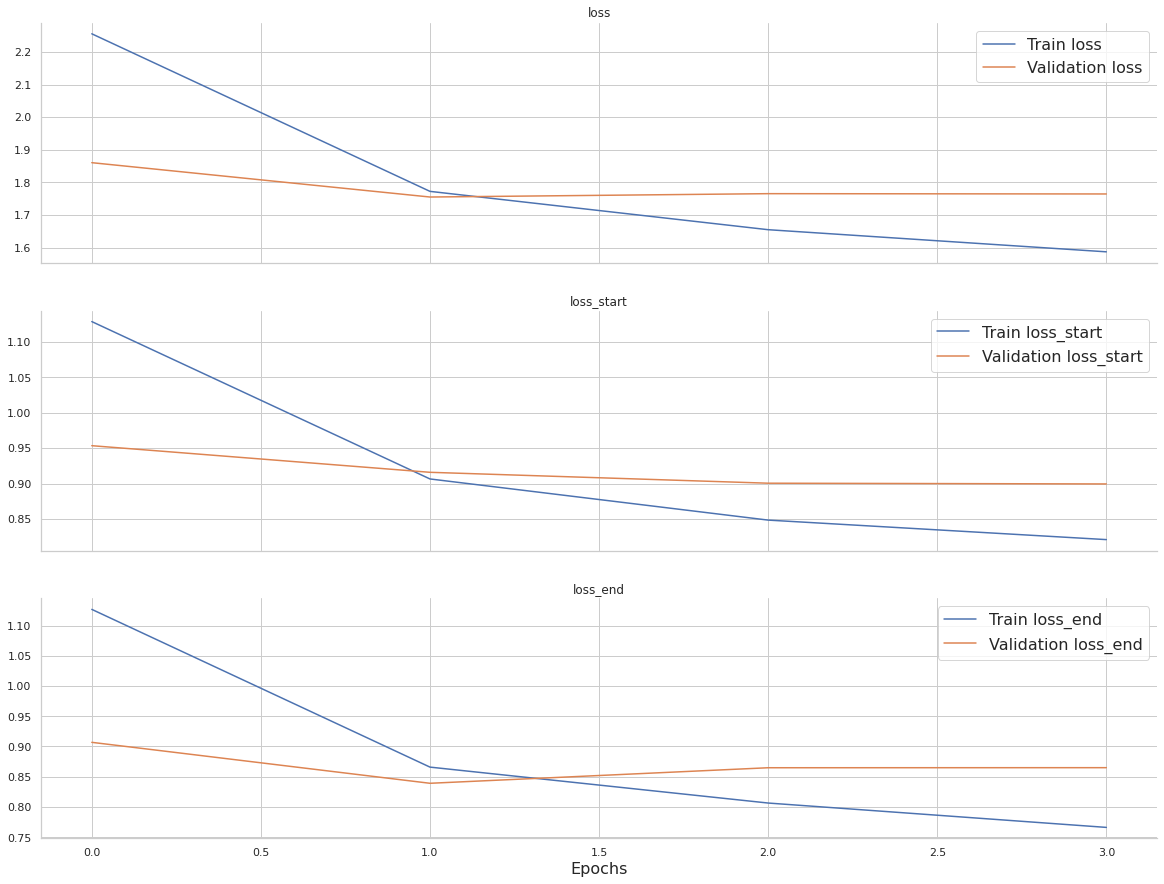

Fold: 2


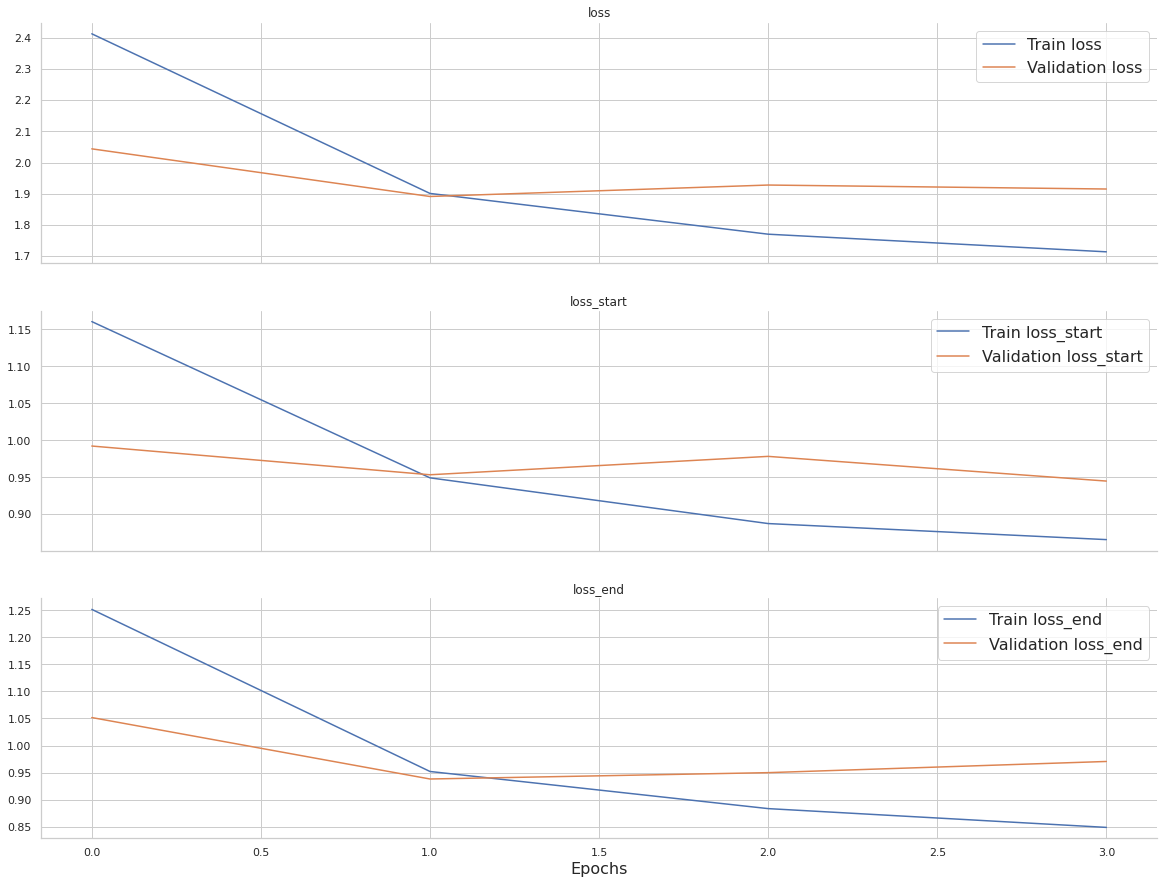

Fold: 3


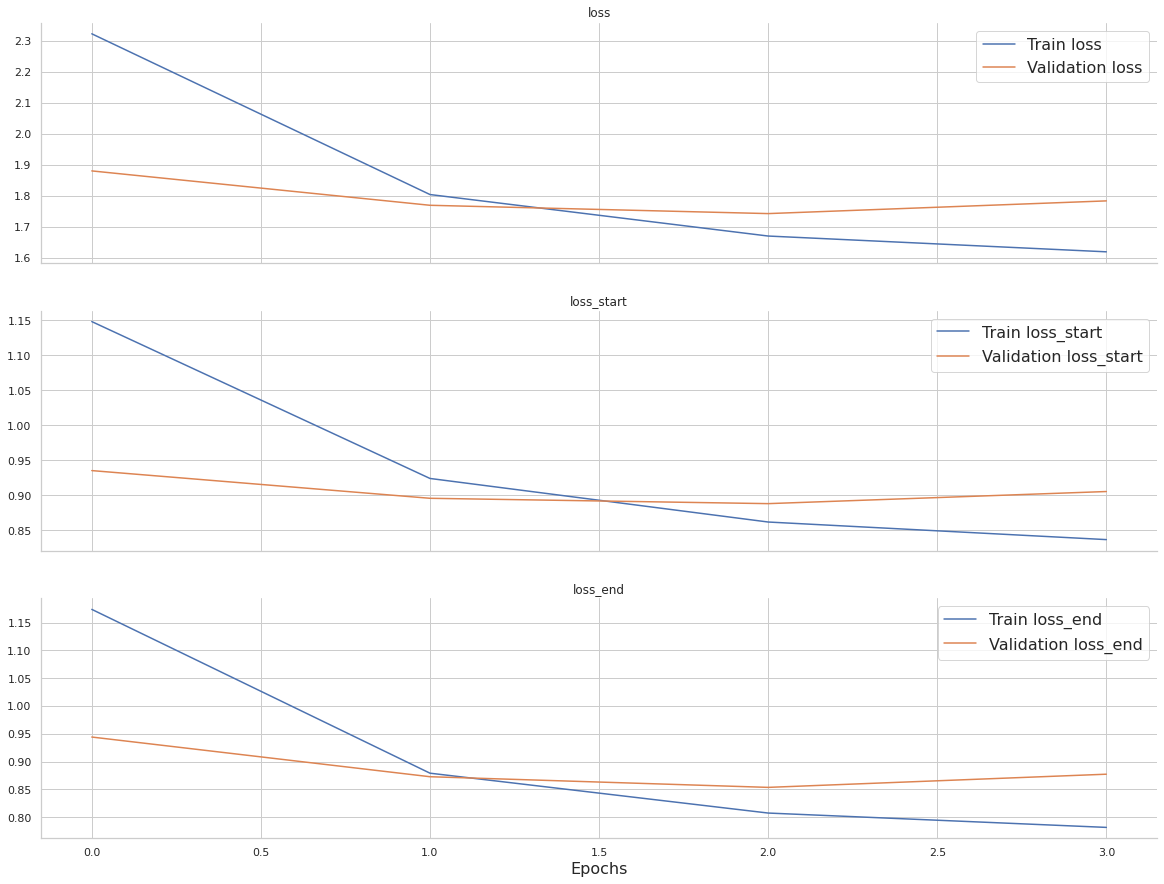

Fold: 4


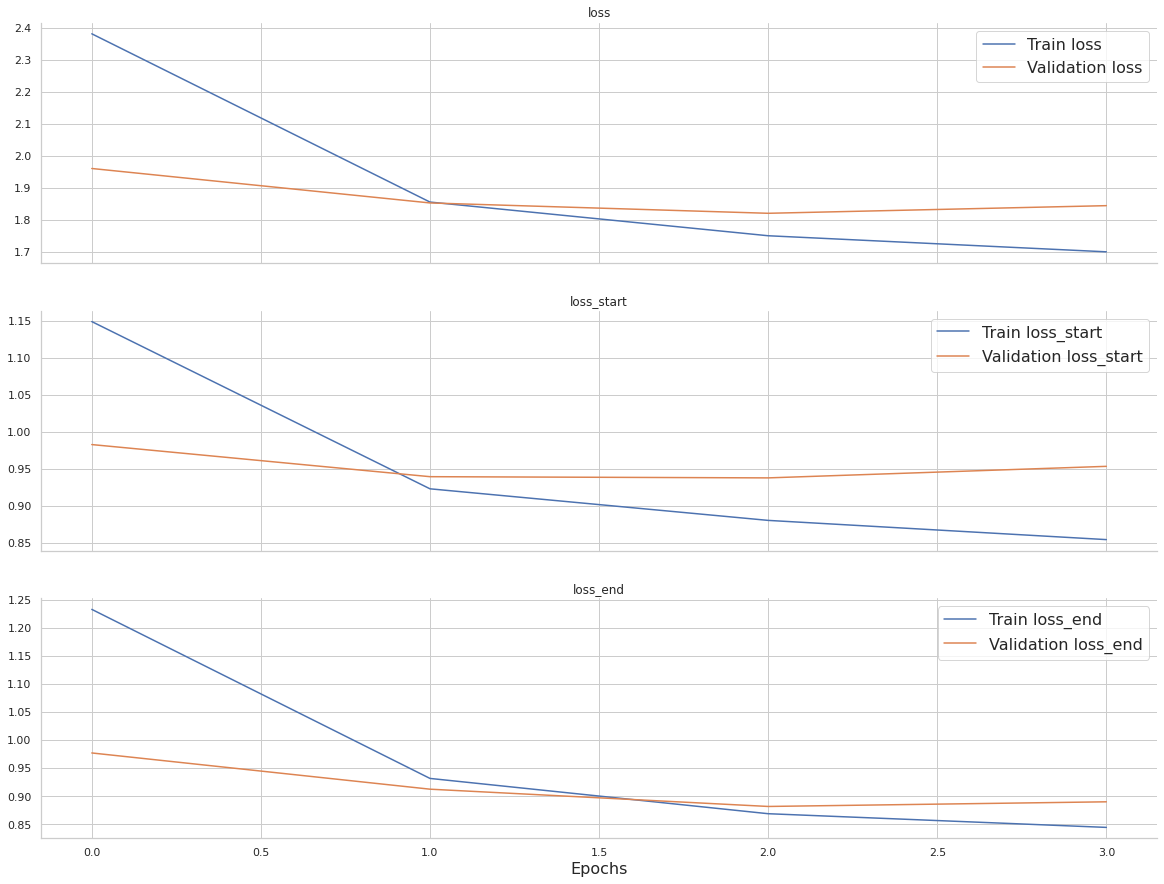

Fold: 5


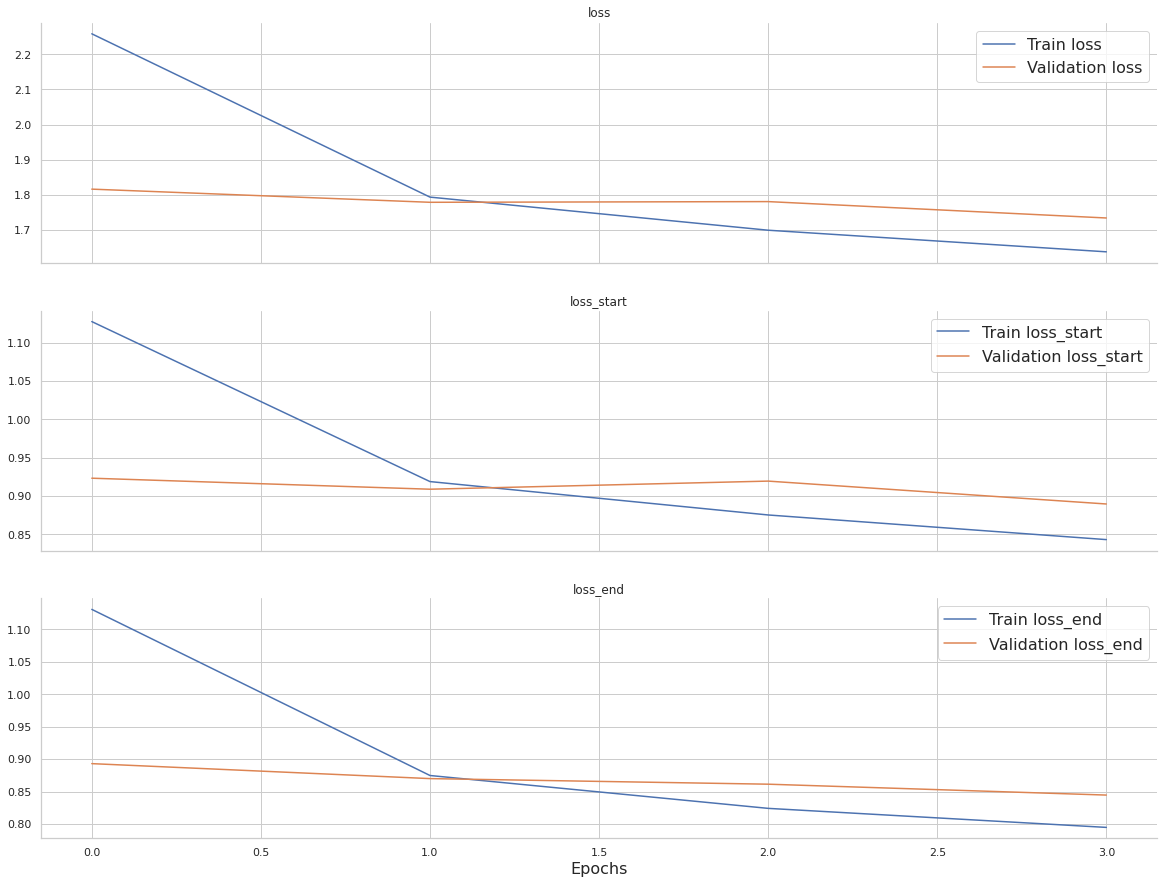

In [15]:
for n_fold in range(config['N_FOLDS']):
    print('Fold: %d' % (n_fold+1))
    plot_metrics(history_list[n_fold])

# Model evaluation (last model)

In [16]:
display(evaluate_model_kfold(k_fold, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric/Jaccard,,,,,,,,,,,,,
Overall,0.698831,0.674309,0.024521,0.708427,0.677788,0.690055,0.663446,0.700589,0.678540,0.694277,0.665876,0.700805,0.685896
Sentiment negative,0.524883,0.479708,0.045176,0.537594,0.487800,0.516039,0.462157,0.524557,0.485206,0.519775,0.471706,0.526452,0.491670
Sentiment neutral,0.972392,0.971215,0.001176,0.976215,0.976819,0.962315,0.960609,0.975962,0.976473,0.970699,0.966929,0.976767,0.975246
Sentiment positive,0.502175,0.466139,0.036036,0.516466,0.462505,0.495189,0.460833,0.503453,0.468003,0.494390,0.452067,0.501378,0.487289
0 <= text wordCnt < 3,0.903420,0.899703,0.003717,0.907051,0.884328,0.901502,0.909492,0.897812,0.914698,0.907273,0.887821,0.903462,0.902174
3 <= text wordCnt < 10,0.752641,0.738503,0.014138,0.761854,0.733791,0.747679,0.736569,0.750927,0.741774,0.751149,0.731275,0.751597,0.749106
10 <= text wordCnt < 30,0.662655,0.631974,0.030681,0.672907,0.639149,0.651250,0.617383,0.666203,0.638129,0.656433,0.621552,0.666482,0.643655
30 <= text wordCnt < 100,0.619968,0.579406,0.040562,0.623336,0.650746,0.627971,0.483059,0.619588,0.574622,0.627065,0.506414,0.601880,0.682187
0 <= selected text wordCnt < 3,0.544202,0.500615,0.043587,0.561160,0.502205,0.542744,0.496190,0.537721,0.496083,0.527011,0.479209,0.552373,0.529385


# Model evaluation (best model)

In [17]:
display(evaluate_model_kfold(k_fold_best, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric/Jaccard,,,,,,,,,,,,,
Overall,0.694045,0.673935,0.020109,0.699847,0.678611,0.679484,0.660259,0.697354,0.675533,0.692734,0.669378,0.700805,0.685896
Sentiment negative,0.515661,0.480213,0.035448,0.527400,0.489547,0.493764,0.459060,0.518051,0.480571,0.512637,0.480216,0.526452,0.491670
Sentiment neutral,0.972985,0.972260,0.000725,0.975804,0.977847,0.964075,0.961912,0.976325,0.976515,0.971955,0.969780,0.976767,0.975246
Sentiment positive,0.494444,0.463130,0.031313,0.498769,0.462226,0.479256,0.451744,0.498522,0.462521,0.494293,0.451872,0.501378,0.487289
0 <= text wordCnt < 3,0.902464,0.900449,0.002015,0.905012,0.888060,0.897898,0.909492,0.898676,0.914698,0.907273,0.887821,0.903462,0.902174
3 <= text wordCnt < 10,0.749589,0.737760,0.011829,0.755394,0.732875,0.740514,0.738432,0.748611,0.738828,0.751830,0.729560,0.751597,0.749106
10 <= text wordCnt < 30,0.656765,0.631727,0.025038,0.662790,0.640966,0.638470,0.611453,0.662320,0.634886,0.653764,0.627677,0.666482,0.643655
30 <= text wordCnt < 100,0.617644,0.587510,0.030134,0.628807,0.638164,0.627505,0.479166,0.614827,0.582364,0.615203,0.555669,0.601880,0.682187
0 <= selected text wordCnt < 3,0.533541,0.496990,0.036551,0.540171,0.496948,0.520520,0.488347,0.523077,0.482446,0.531564,0.487821,0.552373,0.529385


# Visualize predictions

In [18]:
display(k_fold[[c for c in k_fold.columns if not (c.startswith('textID') or 
                                                  c.startswith('text_len') or 
                                                  c.startswith('selected_text_len') or 
                                                  c.startswith('text_wordCnt') or 
                                                  c.startswith('selected_text_wordCnt') or 
                                                  c.startswith('fold_') or 
                                                  c.startswith('start_fold_') or 
                                                  c.startswith('end_fold_'))]].head(15))

,text,selected_text,sentiment,jaccard,text_tokenCnt,selected_text_tokenCnt,prediction_fold_1,jaccard_fold_1,prediction_fold_2,jaccard_fold_2,prediction_fold_3,jaccard_fold_3,prediction_fold_4,jaccard_fold_4,prediction_fold_5,jaccard_fold_5
0,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,1.000000,10,10,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000
1,sooo sad i will miss you here in san diego!!!,sooo sad,negative,0.200000,13,3,sad,0.500000,sad,0.500000,sad,0.500000,sad,0.500000,sad,0.500000
2,my boss is bullying me...,bullying me,negative,0.166667,6,2,bullying,0.500000,bullying me...,0.333333,my boss is bullying me...,0.166667,bullying me...,0.333333,bullying me...,0.333333
3,what interview! leave me alone,leave me alone,negative,0.600000,6,3,what interview! leave me alone,0.600000,what interview! leave me alone,0.600000,what interview! leave me alone,0.600000,what interview! leave me alone,0.600000,what interview! leave me alone,0.600000
4,"sons of ****, why couldn`t they put them on th...","sons of ****,",negative,0.214286,17,4,"sons of ****,",1.000000,"sons of ****,",1.000000,"sons of ****,",1.000000,"sons of ****,",1.000000,"sons of ****,",1.000000
5,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral,1.000000,27,27,http://www.dothebouncy.com/smf - some shameles...,1.000000,http://www.dothebouncy.com/smf - some shameles...,1.000000,http://www.dothebouncy.com/smf - some shameles...,1.000000,http://www.dothebouncy.com/smf - some shameles...,1.000000,http://www.dothebouncy.com/smf - some shameles...,1.000000
6,2am feedings for the baby are fun when he is a...,fun,positive,0.071429,17,1,fun,1.000000,fun,1.000000,fun,1.000000,fun,1.000000,fun,1.000000
7,soooo high,soooo high,neutral,1.000000,3,3,soooo high,1.000000,soooo high,1.000000,soooo high,1.000000,soooo high,1.000000,soooo high,1.000000
8,both of you,both of you,neutral,1.000000,3,3,both of you,1.000000,both of you,1.000000,both of you,1.000000,both of you,1.000000,both of you,1.000000
9,journey!? wow... u just became cooler. hehe.....,wow... u just became cooler.,positive,0.500000,19,7,wow... u just became cooler.,1.000000,journey!? wow... u just became cooler.,0.833333,journey!? wow... u just became cooler.,0.833333,wow...,0.200000,wow... u just became cooler.,1.000000
